In [25]:
from gensim.models import Word2Vec
import pandas as pd
import re
import string
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tejask/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
path='data.csv'
df = pd.read_csv(path)

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [13]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))


In [16]:
''' lemmatization.'''
!python -m spacy download en
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/tejask/opt/anaconda3/lib/python3.8/site-packages/en_core_web_sm -->
/Users/tejask/opt/anaconda3/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [17]:
'''most frequent words'''
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [18]:
'''
min_count: Minimum number of occurrences of a word in the corpus to be included in the model. The higher the number, the less words we have in our corpus.
window: The maximum distance between the current and predicted word within a sentence
size: The dimensionality of the feature vec
workers: no.of cores
model.build_vocab: Prepare the model vocabulary
model.train: Train word vectors
model.init_sims(): When we do not plan to train the model any further, we use this line of code to make the model more memory-efficient.
'''
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

<ipython-input-18-0855f321cc6f>:16: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)


In [19]:
w2v_model.wv.most_similar(positive=['economy'])

[('economic', 0.9809620380401611),
 ('rate', 0.9584279656410217),
 ('growth', 0.9479720592498779),
 ('continue', 0.9157724380493164),
 ('interest', 0.9042111039161682),
 ('low', 0.8939955830574036),
 ('boost', 0.8603487014770508),
 ('job', 0.8538881540298462),
 ('rise', 0.8475426435470581),
 ('price', 0.8385552167892456)]

In [20]:
w2v_model.wv.most_similar(positive=['president'])

[('commission', 0.9595127701759338),
 ('state', 0.9138566255569458),
 ('foreign', 0.9095333218574524),
 ('official', 0.8995581865310669),
 ('trade', 0.8888549208641052),
 ('statement', 0.8833649158477783),
 ('raise', 0.8790497183799744),
 ('investment', 0.8734618425369263),
 ('financial', 0.8732929229736328),
 ('fund', 0.871951699256897)]

In [21]:
w2v_model.wv.similarity('company', 'business')

0.895933

In [22]:
w2v_model.wv.similarity('business', 'investment')

0.85619175

In [23]:
def tsne_plot(model,vocab, perplexity=3, n_iter=1000, figsize=(8,8), xytext=(2,2)):
  labels=[]
  wordvecs=[]
  for word in vocab:
    wordvecs.append(model[word])
    labels.append(word)
  tsne_model = TSNE(perplexity=perplexity, n_components=2, init="pca", random_state=42, n_iter=n_iter)
  coordinates = tsne_model.fit_transform(wordvecs)

  x=[]
  y=[]
  for value  in coordinates:
    x.append(value[0])
    y.append(value[1])
  plt.figure(figsize=figsize)
  for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i],
                 xy=(x[i],y[i]),
                 xytext=xytext,
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.show()


<ipython-input-23-cfb084300df8>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wordvecs.append(model[word])


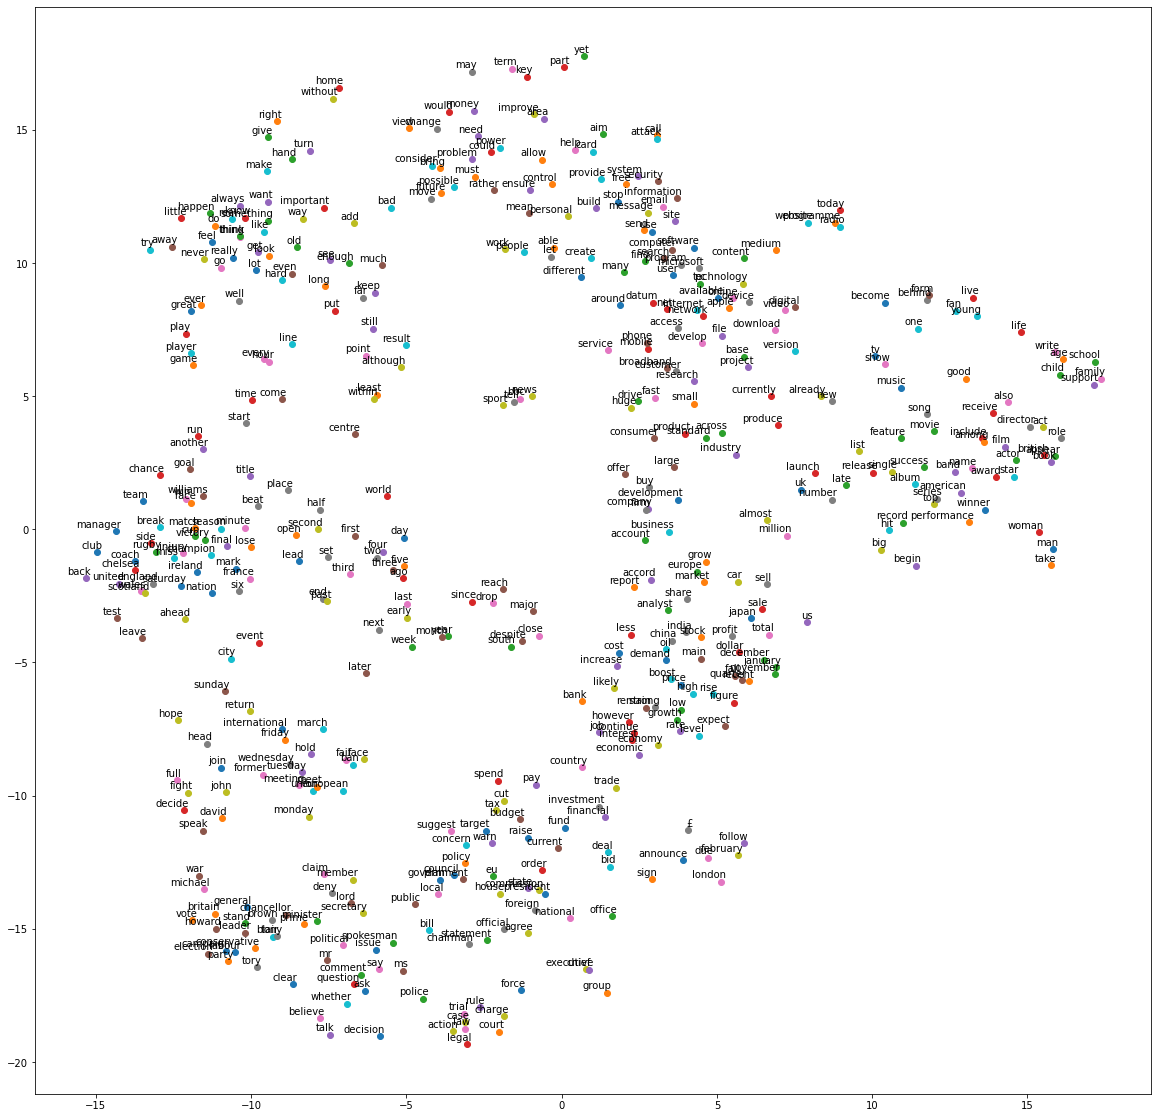

In [26]:
  tsne_plot(w2v_model, w2v_model.wv.vocab, n_iter=2500, perplexity=40, figsize=(20,20), xytext=(5,2))